In [2]:
from time import time
import lightgbm as lgb
import numpy as np
import sys
# sys.path.append('..\Python Scripts\pipeline')
import warnings
warnings.filterwarnings('ignore') 
import seaborn as sns
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.model_selection import KFold, TimeSeriesSplit
from scipy.stats import uniform
import datetime
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from sklearn.feature_selection import RFECV

from scipy import stats
# from hyperopt import hp, tpe
# from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, validation_curve, KFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
%matplotlib inline
import gc
def reduce_memory_usage(df):
    '''
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    '''
    start_mem = df.memory_usage().sum()/1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if (col_type != object) & (col_type != 'datetime64[ns]'):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum()/1024**2
    print('Memory usage: Before|{:.2f} MB || After|{:.2f} MB || Decreased|{:.1f}%'.format(start_mem, end_mem, 100*(1 - end_mem/start_mem)))
    
    return df 
def missing_values_table(df):
    '''
    Функция возвращает таблицу с количеством и долей пропущенных значений в датафрейме
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns

In [3]:
main_path = r'../..'

import sys
sys.path.append(main_path)
from BayDS import *

Using TensorFlow backend.


In [4]:
train_ = pd.read_csv(r'..\..\Data\X_score_agg.csv').set_index('TransactionID')
test_ = pd.read_csv(r'..\..\Data\test_aggs.csv').set_index('TransactionID')

with pd.HDFStore('F:\my\Prog\kaggle\Fraud\hdf\pre-aggregate-no-duplicates.h5') as store:
    data = store[f'data']

train = data[data['isFraud'] != -1]
test = data[data['isFraud'] == -1]

del data
gc.collect()

train_.drop('score', axis=1, inplace=True)

feats = pd.read_csv('..\..\Data\list_time_aggs_v1.csv')
features = feats.iloc[:, 1].tolist()[1:]

X = pd.concat([train, train_[features]], axis=1).drop('isFraud', axis=1)
del train, train_
gc.collect()

test = pd.concat([test, test_[features]], axis=1).drop('isFraud', axis=1)

del test_
gc.collect()

test.drop(3577539, inplace=True)

y = pd.read_pickle(f'f:/my/Prog/kaggle/Baydin/Data/y.pkl')

X.drop('Date', axis=1, inplace=True)
test.drop('Date', axis=1, inplace=True)

# del test
# gc.collect()

In [5]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
          'n_jobs': -1
         }

In [9]:
X.replace(np.inf, -999, inplace=True)
X.replace(-np.inf, -999, inplace=True)
X = X.fillna(-999)


clf = lgb.LGBMClassifier(**params)
rfe = RFECV(estimator=clf, step=0.1, cv=KFold(n_splits=5, shuffle=False), scoring='roc_auc', verbose=2)

print('fit RFE')
rfe.fit(X, y)

fit RFE
Fitting estimator with 628 features.
Fitting estimator with 566 features.
Fitting estimator with 504 features.
Fitting estimator with 442 features.
Fitting estimator with 380 features.
Fitting estimator with 318 features.
Fitting estimator with 256 features.
Fitting estimator with 194 features.
Fitting estimator with 132 features.
Fitting estimator with 70 features.
Fitting estimator with 8 features.
Fitting estimator with 628 features.
Fitting estimator with 566 features.
Fitting estimator with 504 features.
Fitting estimator with 442 features.
Fitting estimator with 380 features.
Fitting estimator with 318 features.
Fitting estimator with 256 features.
Fitting estimator with 194 features.
Fitting estimator with 132 features.
Fitting estimator with 70 features.
Fitting estimator with 8 features.
Fitting estimator with 628 features.
Fitting estimator with 566 features.
Fitting estimator with 504 features.
Fitting estimator with 442 features.
Fitting estimator with 380 features.

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(bagging_fraction=0.4181193142567742,
                               bagging_seed=11, boosting_type='gbdt',
                               class_weight=None, colsample_bytree=1.0,
                               feature_fraction=0.3797454081646243,
                               importance_type='split',
                               learning_rate=0.006883242363721497, max_depth=-1,
                               metric='auc', min_child_samples=20,
                               min_child_we...03454472573214212,
                               min_data_in_leaf=106, min_split_gain=0.0,
                               n_estimators=100, n_jobs=-1, num_leaves=491,
                               objective='binary', random_state=47,
                               reg_alpha=0.3899927210061127,
                               reg_lambda=0.6485237330340494, silent=True,
                               subsamp

In [11]:
print('Optimal number of features:', rfe.n_features_)

lst_time_aggs = []

for col in X.columns[rfe.ranking_ == 1]:
    lst_time_aggs.append(col)
    print(col)

Optimal number of features: 318
TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
dist1
C1
C2
C4
C5
C6
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D8
D10
D11
D15
M3
M4
M5
M6
V20
V38
V45
V53
V54
V56
V61
V62
V70
V78
V83
V87
V126
V127
V128
V130
V131
V143
V165
V187
V189
V201
V207
V217
V258
V266
V277
V279
V280
V282
V283
V285
V291
V294
V306
V307
V308
V310
V312
V313
V314
V315
V317
V323
NanTransactionCount
id_02
id_05
id_06
id_13
id_19
id_20
id_33
DeviceType
DeviceInfo
_Hours
_Days
P_emaildomain_bin
R_emaildomain_bin
OSVersion
device_version
screen_height
card_id
TransactionAmt_decimal
card1_count_full
id_02__id_20
D11__device_name
device_name__P_emaildomain_bin
P_emaildomain_bin__C2
card2__dist1
card1__card5
card2__id_20
card5__P_emaildomain_bin
addr1__card1
id_01_count_full
TransactionAmt_by_card_id_ws1d_to_mean
TransactionAmt_by_card_id_ws1d_to_std
TransactionAmt_by_card_id_ws2d_to_mean
TransactionAmt_by_card_id_ws2d_to_std
TransactionAmt_by_card_id_ws3d_to_mean
TransactionAmt

In [13]:
pd.DataFrame(lst_time_aggs).to_csv('..\..\Data\MEGARFE.csv')

In [19]:
pd.DataFrame(rfe.ranking_).to_csv('..\..\Data\MEGARFE_ranking.csv')

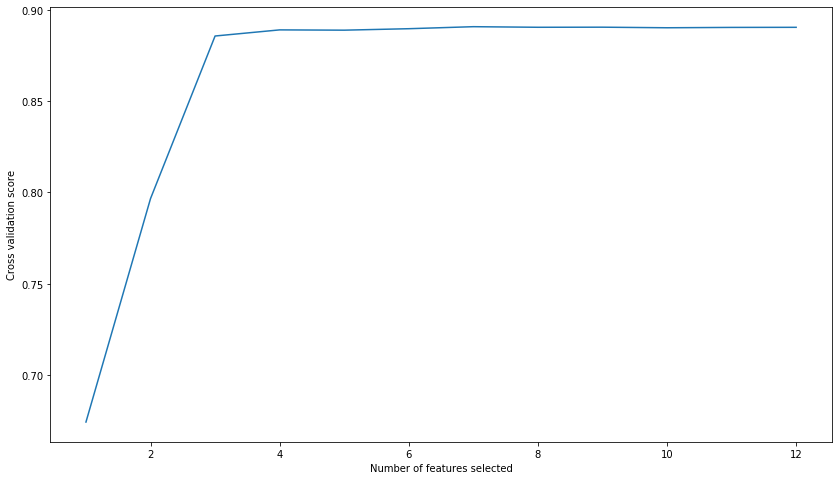

In [25]:
plt.figure(figsize=(14, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [26]:
rfe.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 4, 3, 3, 1, 4, 1, 1, 1, 1, 6,
       5, 5, 6, 5, 4, 6, 6, 6, 6, 6, 6, 3, 2, 5, 3, 1, 4, 5, 5, 6, 4, 2,
       5, 1, 5, 3, 1, 6, 2, 5, 5, 6, 4, 1, 1, 1, 4, 5, 5, 1, 1, 6, 6, 3,
       1, 6, 6, 4, 4, 2, 2, 1, 6, 4, 2, 1, 6, 5, 1, 3, 3, 6, 5, 4, 4, 2,
       3, 2, 5, 1, 1, 1, 1, 1, 6, 5, 5, 1, 5, 5, 5, 2, 6, 6, 5, 6, 3, 6,
       5, 3, 4, 2, 4, 5, 1, 5, 6, 4, 3, 4, 5, 6, 5, 6, 6, 5, 5, 6, 5, 1,
       5, 1, 5, 5, 4, 1, 4, 3, 5, 4, 4, 1, 2, 4, 4, 5, 5, 6, 5, 5, 1, 4,
       5, 5, 5, 4, 5, 5, 5, 6, 5, 6, 4, 5, 4, 5, 5, 5, 4, 4, 5, 4, 5, 5,
       3, 4, 5, 2, 1, 6, 4, 4, 5, 4, 4, 1, 4, 3, 5, 4, 4, 4, 2, 4, 4, 1,
       3, 1, 1, 1, 1, 1, 2, 5, 2, 1, 4, 1, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 6, 6, 4, 4, 2, 4, 5, 6, 1, 2, 1, 4, 6, 1, 1, 6, 6, 3,
       6, 6, 6, 1, 4, 5, 4, 3, 3, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 1,
       5, 6, 6, 6, 4, 1, 1, 3, 3, 1, 1, 1, 4, 1, 6,

In [28]:
X_rfe = X.iloc[:, rfe.support_]

In [34]:
del X
gc.collect()

35

In [33]:
test_rfe = test.iloc[:, rfe.support_]

In [35]:
del test
gc.collect()

7

In [13]:
list_features = pd.read_csv('..\..\Data\MEGARFE.csv').iloc[:,1].tolist()

In [34]:
list_all_std_mean = []
for item in X.columns:
    if 'std' in item or 'mean' in item:
        list_all_std_mean.append(item)

In [36]:
len(list_all_std_mean)

300

In [17]:
list_std_mean = []
for item in list_features:
    if 'std' in item or 'mean' in item:
        list_std_mean.append(item)

In [42]:
f = set(list_all_std_mean) - set(list_std_mean)  

In [32]:
temp = pd.read_pickle(r'..\..\Data\train_09457.pickle')

old_features = temp.drop(['isFraud', 'Date', 'TransactionDT'], axis=1).columns

old_features

Index(['TransactionID', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1',
       ...
       'uid_DT_W', 'uid2_DT_W', 'uid3_DT_W', 'card1_DT_D', 'card2_DT_D',
       'card3_DT_D', 'card5_DT_D', 'uid_DT_D', 'uid2_DT_D', 'uid3_DT_D'],
      dtype='object', length=581)

In [46]:
X_time = X.drop(list(f), axis=1)

In [47]:
test_time = test.drop(list(f), axis=1)

In [48]:
del X, test
gc.collect()

8199

In [49]:
del temp
gc.collect()

14

Fold 1 started at Fri Sep 13 08:05:42 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.990204	training's auc: 0.990204	valid_1's auc: 0.887014	valid_1's auc: 0.887014
[1000]	training's auc: 0.999485	training's auc: 0.999485	valid_1's auc: 0.89491	valid_1's auc: 0.89491
[1500]	training's auc: 0.999956	training's auc: 0.999956	valid_1's auc: 0.897814	valid_1's auc: 0.897814
[2000]	training's auc: 0.999998	training's auc: 0.999998	valid_1's auc: 0.899206	valid_1's auc: 0.899206
[2500]	training's auc: 1	training's auc: 1	valid_1's auc: 0.900109	valid_1's auc: 0.900109
[3000]	training's auc: 1	training's auc: 1	valid_1's auc: 0.900831	valid_1's auc: 0.900831
Early stopping, best iteration is:
[3231]	training's auc: 1	training's auc: 1	valid_1's auc: 0.901011	valid_1's auc: 0.901011
Fold 2 started at Fri Sep 13 09:22:59 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.990191	training's auc: 0.990191	valid_1

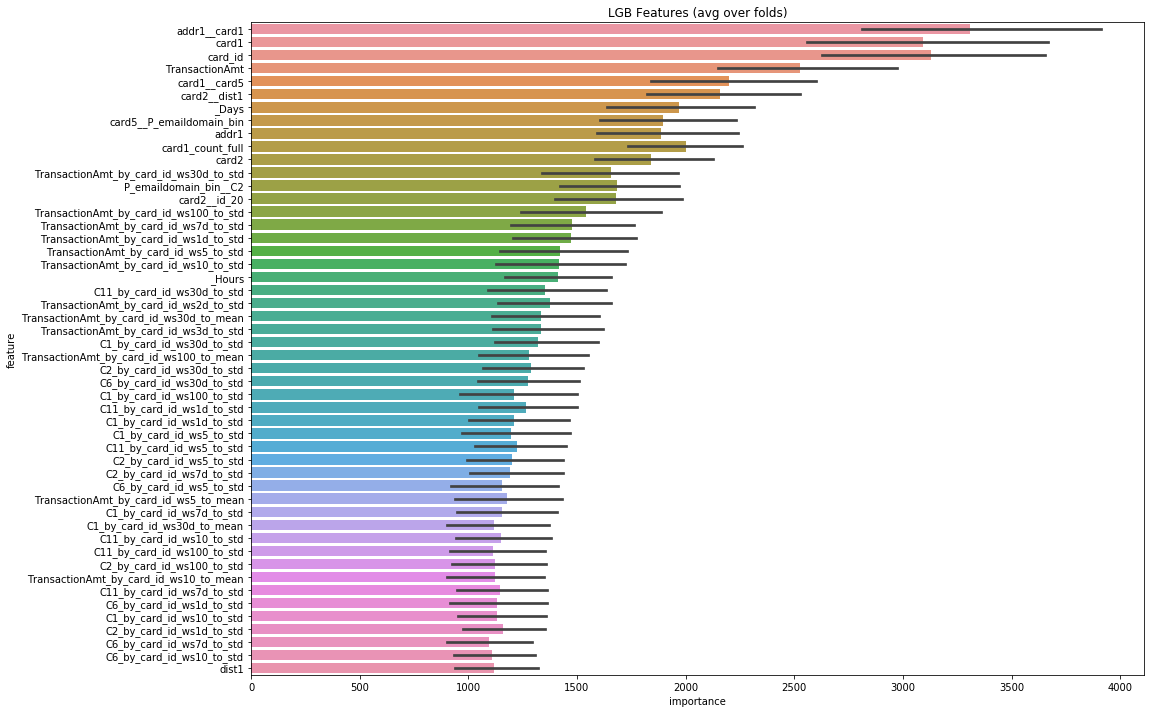

In [50]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }

n_fold = 5
folds = KFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold
    
}
result_dict_lgb_after_rfe = train_model_classification(X=X_time, X_test=test_time, y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

Fold 1 started at Wed Sep 11 23:02:53 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.990626	training's auc: 0.990626	valid_1's auc: 0.886545	valid_1's auc: 0.886545
[1000]	training's auc: 0.999545	training's auc: 0.999545	valid_1's auc: 0.894716	valid_1's auc: 0.894716
[1500]	training's auc: 0.999962	training's auc: 0.999962	valid_1's auc: 0.897291	valid_1's auc: 0.897291
[2000]	training's auc: 0.999998	training's auc: 0.999998	valid_1's auc: 0.898614	valid_1's auc: 0.898614
[2500]	training's auc: 1	training's auc: 1	valid_1's auc: 0.899675	valid_1's auc: 0.899675
[3000]	training's auc: 1	training's auc: 1	valid_1's auc: 0.900367	valid_1's auc: 0.900367
Early stopping, best iteration is:
[3119]	training's auc: 1	training's auc: 1	valid_1's auc: 0.900362	valid_1's auc: 0.900362
Fold 2 started at Thu Sep 12 01:24:17 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.990709	training's auc: 0.990709	valid

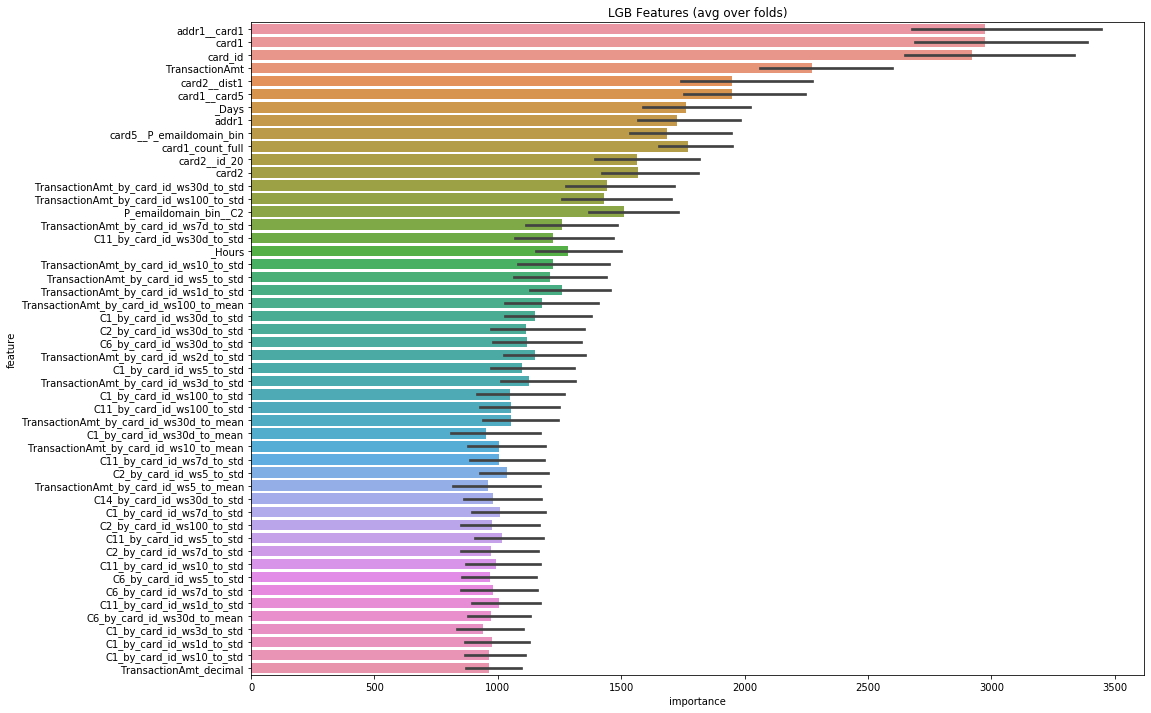

In [31]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }

n_fold = 5
folds = KFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold
    
}

result_dict_lgb = train_model_classification(X=X, X_test=test, y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

In [32]:
X = X.drop(features, axis=1)
test = test.drop(features, axis=1)

In [33]:
result_dict_lgb_ = train_model_classification(X=X, X_test=test, y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

Fold 1 started at Thu Sep 12 08:02:23 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.980766	training's auc: 0.980766	valid_1's auc: 0.902296	valid_1's auc: 0.902296


KeyboardInterrupt: 

In [38]:
pd.DataFrame(result_dict_lgb['prediction'], index=test.index, columns=['isFraud']).to_csv('ieee-with-time-aggs-v2.csv')

In [35]:
result_dict_lgb['prediction']

array([[0.00034721],
       [0.000725  ],
       [0.00274554],
       ...,
       [0.00214056],
       [0.00151192],
       [0.00105652]])

In [62]:
corrs = X.corr()

In [63]:
X.iloc[:, 450:460]

,C10_by_card_id_ws2d_to_mean,C10_by_card_id_ws2d_to_std,C10_by_card_id_ws3d_to_std,C10_by_card_id_ws7d_to_mean,C10_by_card_id_ws7d_to_std,C10_by_card_id_ws30d_to_mean,C10_by_card_id_ws30d_to_std,C10_by_card_id_ws5_to_std,C10_by_card_id_ws10_to_mean,C10_by_card_id_ws10_to_std
TransactionID,,,,,,,,,,
2987000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,1.0000,NaN,NaN,1.000,NaN,1.000,NaN,NaN,1.0000,NaN
2987005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987008,1.0000,NaN,NaN,1.000,NaN,1.000,NaN,NaN,1.0000,NaN


In [64]:
corrs[corrs>0.9].loc[]

SyntaxError: invalid syntax (<ipython-input-64-6b691fd940bd>, line 1)

In [4]:
X = train.sort_index().drop(['isFraud'], axis=1)
y = train.sort_index()['isFraud'].astype(np.uint8)
test = test.sort_index()

X.drop('Date', axis=1, inplace=True)
X=X.astype(np.float32)
test.drop('Date', axis=1, inplace=True)
test=test.astype(np.float32)

del train
gc.collect()

49

In [5]:
X_time = pd.read_csv('X_score_agg.csv').set_index('TransactionID')

feats = pd.read_csv('list_time_aggs_v1.csv')
features = feats.iloc[:, 1].tolist()[1:]
X_time = X_time[features]

X = X_time.join(X)

del X_time
gc.collect()

49

In [15]:
X.shape

(590540, 628)

In [16]:
test.shape

(506691, 628)

In [6]:
test_time = pd.read_csv('test_aggs.csv').set_index('TransactionID')[features]

In [7]:
test_time.drop(3577539, inplace=True)

In [27]:
test_time.shape

(506691, 300)

In [8]:
test = test.join(test_time).drop('isFraud', axis=1)

Fold 1 started at Wed Sep 11 16:36:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[28]	training's auc: 0.958248	training's auc: 0.958262	valid_1's auc: 0.902131	valid_1's auc: 0.902115
Fold 2 started at Wed Sep 11 16:39:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[28]	training's auc: 0.957192	training's auc: 0.957201	valid_1's auc: 0.926459	valid_1's auc: 0.926476
Fold 3 started at Wed Sep 11 16:42:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[28]	training's auc: 0.956093	training's auc: 0.956096	valid_1's auc: 0.93007	valid_1's auc: 0.930097
Fold 4 started at Wed Sep 11 16:46:09 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.989872	training's auc: 0.989872	valid_1's auc: 0.944281	valid_1's auc: 0.944281
[1000]	training's auc: 0.998476	training's auc: 0.998476	va

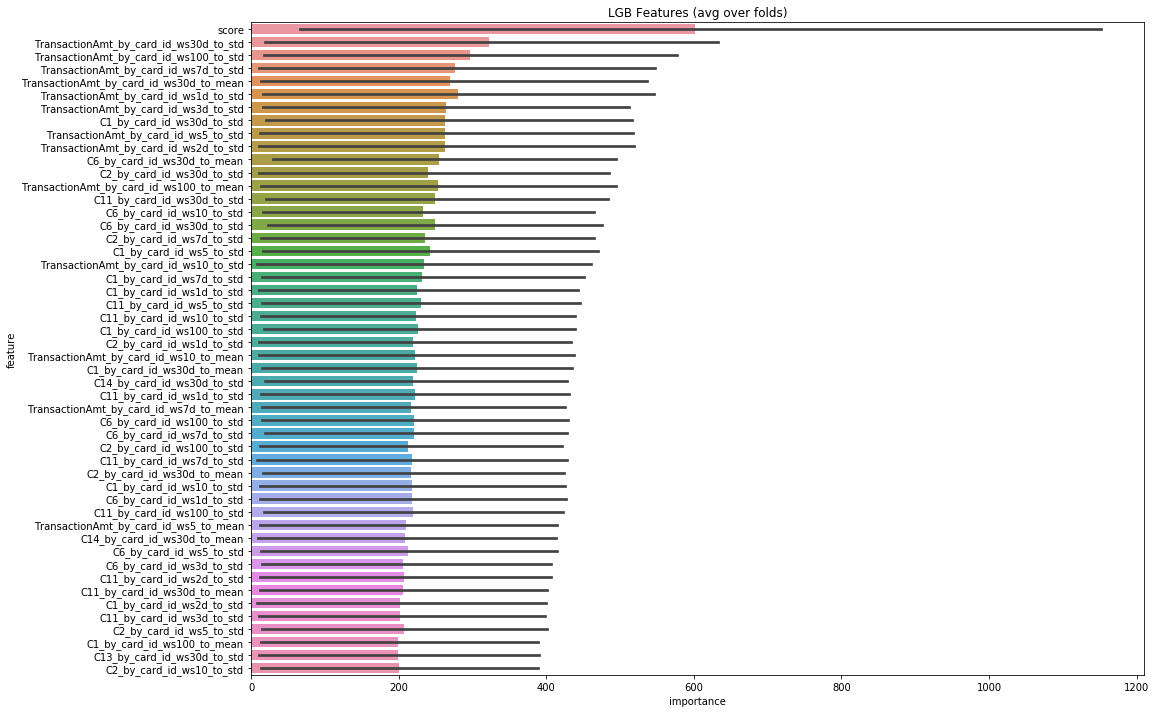

In [77]:
result_dict_lgb = train_model_classification(X=X, X_test=test, y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

In [85]:
pd.DataFrame(result_dict_lgb['prediction'], index=testscore.index, columns=['isFraud']).to_csv('ieee-with-time-aggs-v1.csv')